# An Analysis of the OSI SAF Ice Concentration Filtered (*Beta*) Product

Spurious ice can occur in the OSI SAF sea ice concentration fields, due to weather effects the uncertainty of the measurement over open water.

The ice concentration field is filtered to remove this spurious ice. This notebooks shows an analysis of the ice conentration removed for a given day.

In [12]:
%matplotlib inline
from pylab import *
import seaborn as sb
import xarray as xa
import pyresample as pr
from cmocean import cm
import pandas as pd
from scipy.constants import golden
import calendar

#### Load the NetCDF file

In [17]:
ncfname = 'data/ice_conc_nh_polstere-100_multi_201612201200.nc'
ds = xa.open_dataset(ncfname)
ds = ds.assign(ice_conc_diff = ds.ice_conc_unfiltered - ds.ice_conc)
time_str = ds.time.to_pandas().index[0].strftime('%Y-%m-%d')
print('The ice concentration is analyed for the day: {}'.format(time_str))

The ice concentration is analyed for the day: 2016-12-20


In [18]:
def bmap_setup(path_area_config, projection, hm, ax):
    area_def = pr.utils.load_area(path_area_config, '{0}_{1}'.format(projection, hm))
    bmap = pr.plot.area_def2basemap(area_def)
    bmap.ax = ax
    bmap.drawcoastlines()
    parallels = np.arange(-360, 360, 10)
    bmap.drawparallels(parallels, labels=[0, 0, 0, 0], fontsize=10)
    meridians = np.arange(0., 360., 10)
    bmap.drawmeridians(meridians, labels=[0, 0, 0, 0], fontsize=10)
    return bmap, (bmap.xmin,bmap.xmax,bmap.ymin,bmap.ymax)

cm.thermal.set_bad(color='0.85')
cm.ice.set_bad(color='0.85')

def plot_map(data, title, map_type, ax):
    bmap, extent = bmap_setup('cfg/areas.cfg', 'OSISAF', 'NH', ax)
    kwargs = {'mask': dict(cmap='Greys', extent=extent, aspect=1, add_colorbar=False),
              'ice': dict(cmap=cm.ice, extent=extent, aspect=1),
              'thermal': dict(cmap=cm.thermal, extent=extent, aspect=1),
              'default': dict(extent=extent, aspect=1)}
    data.plot.imshow(ax=ax, **kwargs[map_type])
    ax.set_title(title)

### The Masks

The mask used to filter out spurious ice is created from a combination of four masks:
  * The open water mask
  * The 2m temperature mask
  * The climatology mask
  * The land mask
  
The *open water mask*, effectively, removes low ice concentrations. It also removes some valid ice at the ice edge.

The *2m temperature mask* removes ice where the temperature at 2m is greater or equal to $8^\circ C$.

The *climatology mask* is based on historical records and is different of each month.

The land mask has been dilated, in order to include around the coast and thereby reduce the land spillover.

The following are plots of these masks:

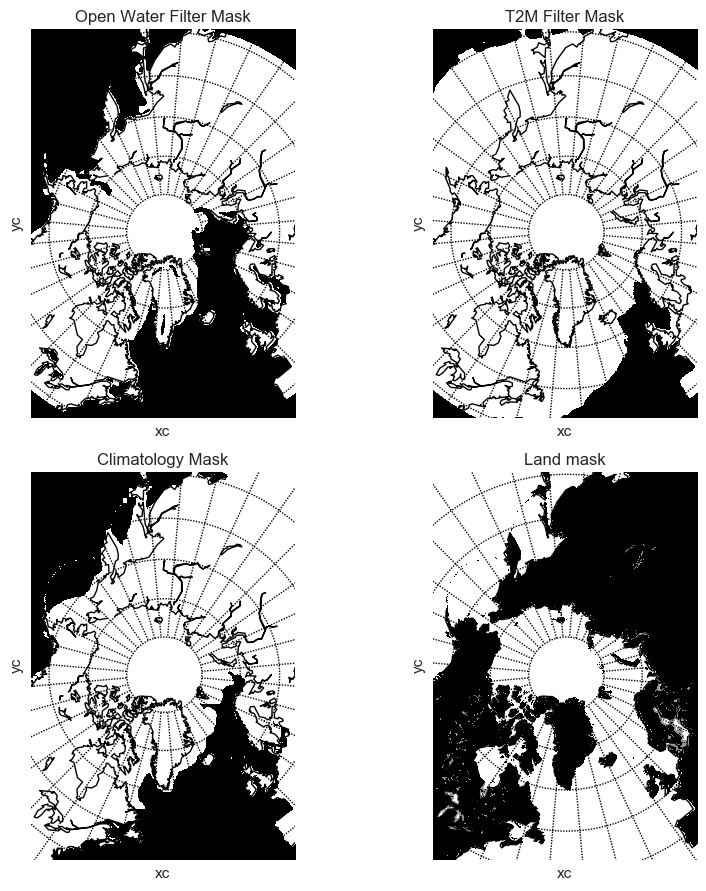

In [19]:
lmask = xa.open_dataset('masks/lmask_nh_stere_100.nc')

fig, ((ax1, ax2), (ax3, ax4)) = subplots(2,2)
fig.set_size_inches(9,9)
plot_map(ds.mask_owf[0], 'Open Water Filter Mask', 'mask', ax1)
plot_map(ds.mask_t2m[0], 'T2M Filter Mask', 'mask', ax2)
plot_map(ds.mask_ocean[0], 'Climatology Mask', 'mask', ax3)
plot_map(lmask.lakecoastfilter_250, 'Land mask', 'mask', ax4)
tight_layout()
show()

The *black* regions are used to mask the ice concentration field.

The mask used to filter the ice concentration is a combination of these as, such that if any of these masks are true the ice is applied. So the mask applied is as follows:

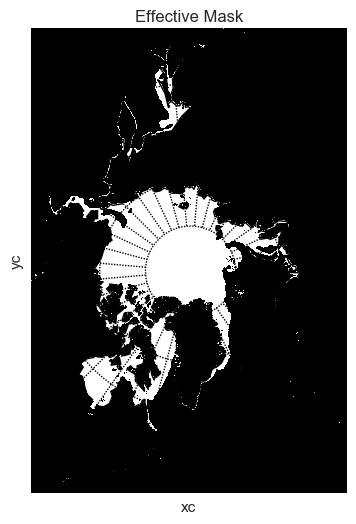

In [20]:
fig, ax = subplots(1)
fig.set_size_inches(12, 6)
d = np.logical_or(np.logical_or(ds.mask_owf[0], ds.mask_t2m[0]), 
                  np.logical_or(ds.mask_ocean[0], lmask.lakecoastfilter_250))
plot_map(d, 'Effective Mask', 'mask', ax)

The open water filter and 2 m temperature masks change on a daily basis. Whereas, the climatology mask changes every month. Additional, areas (e.g. around Iceland and and Japan) are masked out. Other areas will be masked on an ad hoc bases, if spurious occurs there regions. Change 'month_idx' below to select another month.

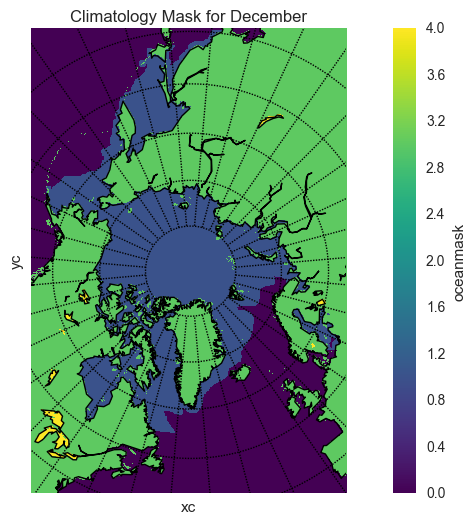

In [21]:
month_idx = 11
mth = calendar.month_name[month_idx + 1]
omask = xa.open_dataset('masks/oceanmask_nh_stere_100.nc')
fig, ax = subplots(1)
fig.set_size_inches(12, 6)
plot_map(omask.oceanmask[0],'Climatology Mask for {}'.format(mth), 'default', ax)

#### Plots of the filtered, unfiltered and the difference between them

The following plots show the ice concentration before and after filtering, in addtion to the difference between them. 

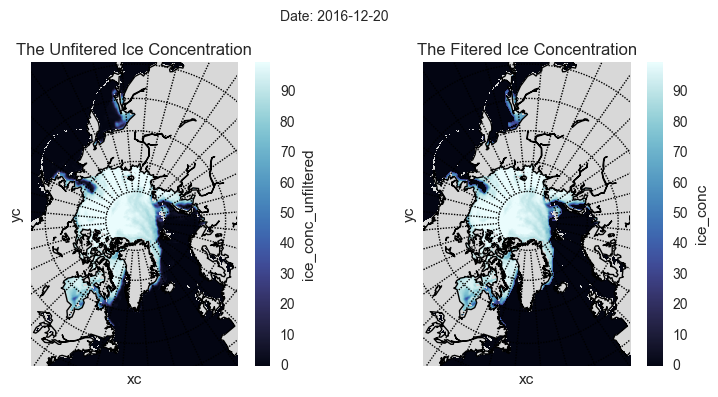

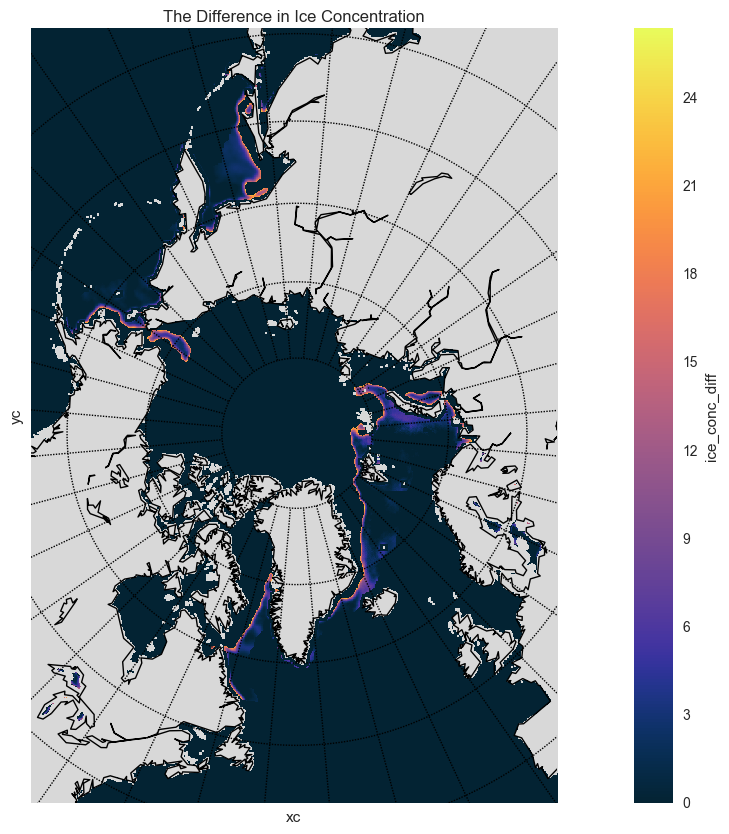

In [22]:
# Plot the filtered and unfiltered ice concentrations
fig, (ax1, ax2) = subplots(1,2)
fig.set_size_inches(8, 4)
suptitle('Date: {}'.format(time_str), fontsize=10)
plot_map(ds.ice_conc_unfiltered[0], 'The Unfitered Ice Concentration', 'ice', ax1)
plot_map(ds.ice_conc[0], 'The Fitered Ice Concentration', 'ice', ax2)
tight_layout()
fig.subplots_adjust(top=0.85)
show()

# Plot the difference between the filtered Ice Concentration
fig, ax = subplots(1)
fig.set_size_inches(20, 10)
plot_map(ds.ice_conc_diff[0], 'The Difference in Ice Concentration', 'thermal', ax)

Note that dilated land mask has been applied to both the filtered and unfiltered ice concentration fields.

#### The  "quanity" of ice removed

The difference in ice concentration, $\mathit{diff}_{xy}$, is totaled and divided be the total unfiltered $\mathit{unfilt}_{xy}$ ice concentration to give a figure representing the percentage of ice removed, as follows:
$$ 100  \frac{ \sum_{x = 1}^{n_x} \sum_{y = 1}^{n_y} \mathit{diff}_{xy} }{ \sum_{x = 1}^{n_x} \sum_{y = 1}^{n_y} \mathit{unfilt}_{xy} },$$

where the $\mathit{diff}_{xy}$ is the difference in ice concentration between the unfiltered and filtered ice concentration fields: $\mathit{unfilt}_{xy} - \mathit{filt}_{xy}$.

where $\mathit{unfilt}_{xy}$ is the unfiltered ice concentration.

In [23]:
diff_sum = ds.ice_conc_diff.sum().values
unfilt_sum = ds.ice_conc_unfiltered.sum().values
removed = 100 * (diff_sum/unfilt_sum)
print('A total of {:.1f} % of the ice is removed by the filters'.format(removed))

A total of 1.3 % of the ice is removed by the filters


#### The distribution of Difference In Ice Concentration

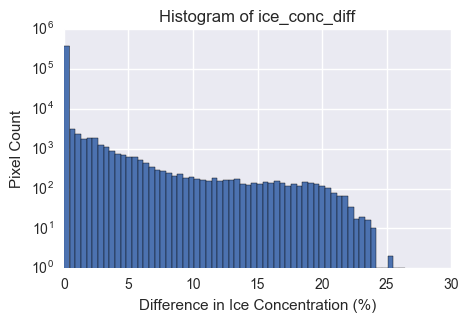

In [24]:
l = 5
fig, (ax) = subplots(1, figsize=(l, l/golden))
a = ds.ice_conc_diff.plot.hist(bins=60, ax=ax)
xlim(0,30)
xlabel('Difference in Ice Concentration (%)')
ylabel('Pixel Count')
ax.set_yscale("log")
ax.grid(b=True, which='major', color='w', linewidth=1.0)

#### The disribution of filtered and unfiltered pixel values

The following plot is a heat map showing the distrubution of the binned ice concentrations pixel values. A count of the pixel values is given in each cell.

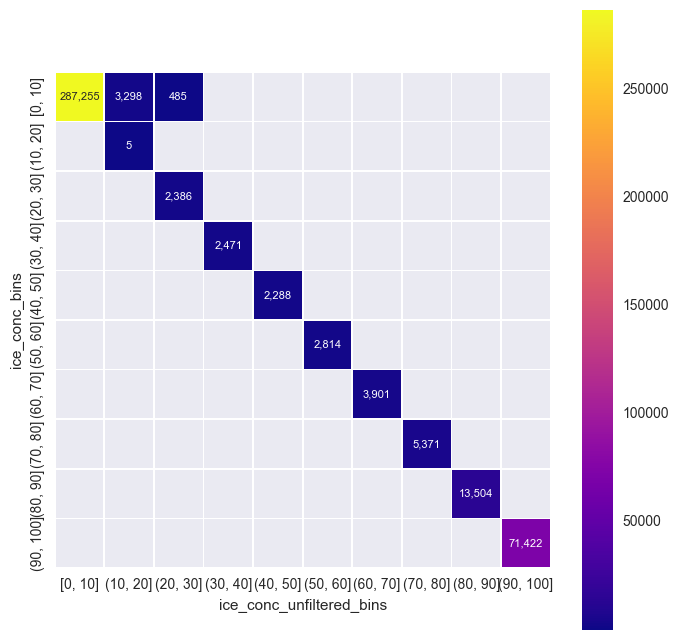

In [31]:
df = ds[['ice_conc', 'ice_conc_unfiltered']].to_dataframe().reset_index().dropna()
df['ice_conc_bins'] = pd.cut(df['ice_conc'], range(0,101, 10), right=True, include_lowest=True)
df['ice_conc_unfiltered_bins'] = pd.cut(df['ice_conc_unfiltered'], range(0,101, 10), 
                                        right=True, include_lowest=True)

pt = pd.pivot_table(df, values='ice_conc', index=['ice_conc_bins'], columns=['ice_conc_unfiltered_bins'],
                           aggfunc=len)
pt.fillna(0)
fig, ax = plt.subplots(figsize=(8,8))     
sb.heatmap(pt, annot=True, fmt=',.0f', linewidths=.5, cmap=plt.cm.plasma, square=True, 
           annot_kws={"size": 8}, cbar=True, ax=ax);

The filtering sets somes of the lower ice concentration pixels to zero.